In [ ]:
!curl -LO https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-t-ffhq-1024x1024.pkl
!git clone https://github.com/NVlabs/stylegan3
!cd stylegan3
!cp ./stylegan3/dnnlib ./dnnlib -r
!cp ./stylegan3/torch_utils ./torch_utils -r
!pip install tflearn
!pip install lpips
!pip install ninja
!pip install einops ninja
!pip install legacy
!git clone https://github.com/openai/CLIP
!pip install -e ./CLIP

import os
import pickle
import tflearn
import torchvision.transforms.functional as TF
import torchvision.utils
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from numpy.core.fromnumeric import resize
from torch.nn.modules.conv import Conv2d
from torchvision import datasets, transforms
import lpips
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import sys
import legacy
sys.path.append('./stylegan3')
from google.colab import drive
from torch.utils.data import Dataset
import cv2
from torchvision.io import read_image
from PIL import Image
import cv2
from CLIP.clip import clip
from tqdm import tqdm

device = 'cuda'
class Encoder_block(nn.Module):
    def __init__(self , channels_in , channels_out ,  kernel_size =3 , stride = 2 , padding=1):
        super(Encoder_block, self).__init__()
        self.conv=Conv2d(channels_in ,channels_out ,kernel_size , stride=stride , padding=padding )
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x


class Encoder(nn.Module):
    def __init__(self ):
        super(Encoder, self).__init__()
        layers_List = []
        layers_List.append(Encoder_block(3,4))#128
        layers_List.append(Encoder_block(4,8)) #64
        layers_List.append(Encoder_block(8,16)) #32
        layers_List.append(Encoder_block(16,32)) #16
        layers_List.append(Encoder_block(32,64)) #8
        layers_List.append(Encoder_block(64,128)) #4
        layers_List.append(Encoder_block(128,256)) #2
        layers_List.append(nn.Conv2d(256,512,2)) #1  
        self.encoder = nn.Sequential(*layers_List).cuda()


    def forward(self, x):
        encoded = self.encoder(x).to(device)
        encoded = encoded.view(-1,512)

        return encoded


tf = Compose([
  Resize(224),
  lambda x: torch.clamp((x+1)/2,min=0,max=1),
  ])



class CLIPLoss(torch.nn.Module):
    def __init__(self):
        super(CLIPLoss, self).__init__()
        self.model, self.preprocess = clip.load("ViT-B/32", device="cuda")
    def forward(self, image, text):
        image = torch.nn.functional.interpolate(image , size=245)
        similarity = 1 - self.model(image, text)[0] / 100
        return similarity


def get_concat_h(im1, im2 , im3):
    dst = Image.new('RGB', (im1.width + im2.width +im3.width  , im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    dst.paste(im3, (im1.width+im2.width , 0))
    return dst


def All_Model(image , text):

   
  #Loading Pretrained stylegan 3 module
  with open('stylegan3-t-ffhq-1024x1024.pkl', 'rb') as f:
      G = pickle.load(f)['G_ema'].cuda()


  transform = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,), (0.5,)),
                                ])



  image = transform(image)

  tf = Compose([
  Resize(224),
  lambda x: torch.clamp((x+1)/2,min=0,max=1),
  ])

  #Generation
  model = Encoder().eval()
  generator = G.eval()
  model_V = torch.load("/content/drive/MyDrive/3rd_model_W/12th_Epoch_model.pth")
  model.load_state_dict(model_V.state_dict())
  image = image.to(device)
  #manipulation
  ClipLoss = CLIPLoss()
  latent = generator.mapping(model(image).cuda().clone().detach(), None)
  latent_cpy = latent.clone().detach()
  gen_img = generator.synthesis(latent).clone().detach()
  criterion = nn.MSELoss().cuda()
  latent.requires_grad_(True)
  text_input = torch.cat([clip.tokenize(text)]).cuda()
  optimizer = torch.optim.Adam([latent], lr=0.005)
  number_of_optimization_iterations = 60
  loss_fn = lpips.LPIPS(net='vgg').cuda()
  for step in (range(number_of_optimization_iterations)):
      manipulated = generator.synthesis(latent)
      #if (step%10 == 0):
        #display(TF.to_pil_image(tf(manipulated)[0]))
      loss = ClipLoss(manipulated , text_input)[0][0] * 120
      loss += loss_fn(manipulated , gen_img)[0][0][0][0] * 20
      loss += criterion(latent, latent_cpy) *20
      loss += criterion(manipulated , gen_img) *20
      loss += ((manipulated - gen_img).abs().mean() * 20)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  
  return gen_img , manipulated
  

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


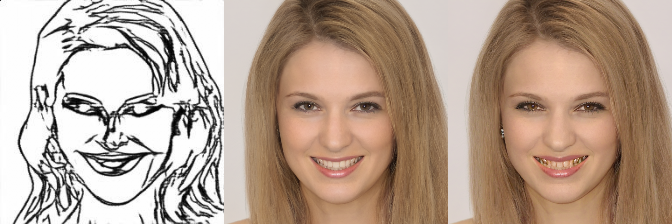

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


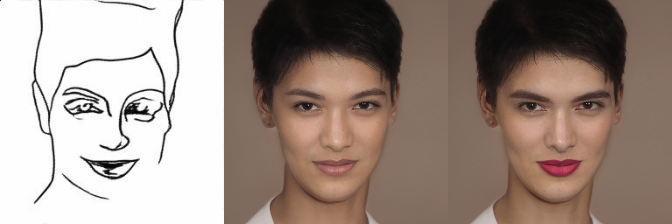

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


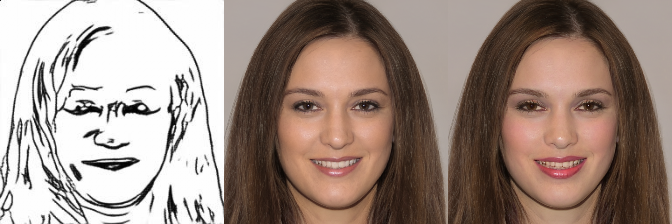

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


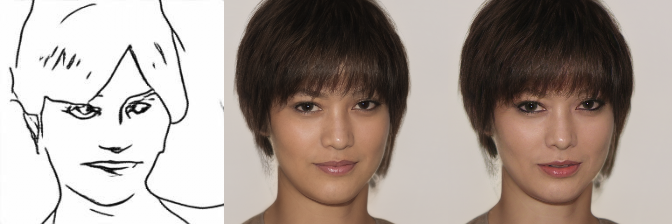

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


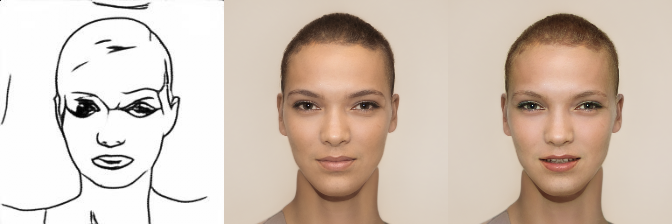

In [26]:
transform = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,), (0.5,)),
                                ])
for index in range(205,210):
  sketch_path = '/content/sketch/' +str(index) + '.jpg'
  sketch_image = read_image(sketch_path)  
  text_path = '/content/text/' +str(index) + '.txt'
  text = ''
  with open(text_path , 'rb') as f:
    lines = f.readlines()
    text = lines[1]
  gen , Manp = All_Model(sketch_image , str(text))
  sketch_image = transform(sketch_image)
  im = get_concat_h(TF.to_pil_image(tf(sketch_image)[0]) , TF.to_pil_image(tf(gen)[0]) , TF.to_pil_image(tf(Manp)[0]))
  display(im)

